                             0
Network Transmission     0.891
Image Save               2.128
Image Preprocessing      5.811
Model Inference         16.583
QoE Computation          0.028
Broker Handling          1.111
Response JSON Creation   0.140
Total                   26.693
RTT                     30.462
Unaccounted Overhead     3.769


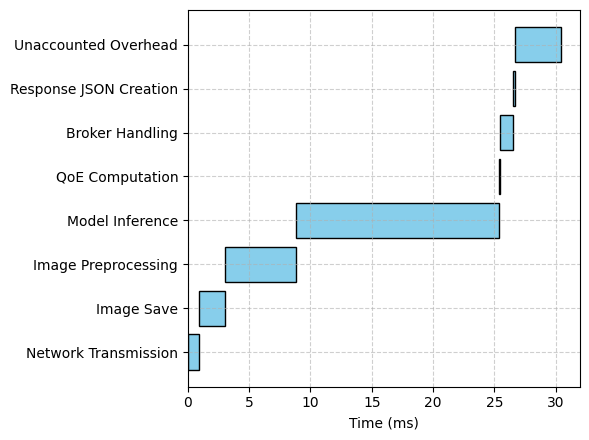

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_request_latencies(df):
    df["Network Transmission"] = df["network_time"] * 1000

    df["Image Save"] = (df["image_save_time"] - df["server_receive_time"]) * 1000
    df["Image Preprocessing"] = (df["image_preprocessed_time"] - df["image_save_time"]) * 1000
    df["Model Inference"] = (df["image_predicted_time"] - df["image_preprocessed_time"]) * 1000
    df["QoE Computation"] = (df["qoe_computed_time"] - df["image_predicted_time"]) * 1000
    df["Broker Handling"] = (df["event_produced_time"] - df["qoe_computed_time"]) * 1000
    df["Response JSON Creation"] = (df["response_create_time"] - df["event_produced_time"]) * 1000

    # Calculate total processing time
    df["Total"] = (
        df["Network Transmission"] +
        df["Image Save"] +
        df["Image Preprocessing"] +
        df["Model Inference"] +
        df["QoE Computation"] +
        df["Broker Handling"] +
        df["Response JSON Creation"]
    )

    df["RTT"] = (df["client_receive_time"] - df["client_send_time"]) * 1000
    df["Unaccounted Overhead"] = df["RTT"] - df["Total"]

    # Return a DataFrame with selected columns for better visualization
    return df[[
        "Network Transmission",
        "Image Save",
        "Image Preprocessing",
        "Model Inference",
        "QoE Computation",
        "Broker Handling",
        "Response JSON Creation",
        "Total",
        "RTT",
        "Unaccounted Overhead"
    ]]

# Load and process the datasets
results_ckn = pd.read_csv("results_ckn.csv")
results_ckn = analyze_request_latencies(results_ckn)
print(results_ckn.mean().round(3).to_frame())
results_mean = results_ckn.mean().round(3).to_frame().T.drop(columns=["RTT", "Total"])

# Prepare Gantt chart data, filter out tasks with zero duration
task_durations = results_mean.iloc[0].to_dict()
df = pd.DataFrame.from_dict(task_durations, orient='index', columns=["Duration"])

# Filter out rows where Duration is zero
df = df[df['Duration'] > 0]

# Calculate start and end times for each task
df["Start"] = df["Duration"].cumsum() - df["Duration"]
df["End"] = df["Duration"].cumsum()

# Plot Gantt Chart
fig, ax = plt.subplots(figsize=(6, 4.5))

# Plot each task as a horizontal bar
for task, row in df.iterrows():
    ax.barh(task, row["Duration"], left=row["Start"], color="skyblue", edgecolor="black")

# Add labels and grid
ax.set_xlabel("Time (ms)")
ax.grid(True, linestyle="--", alpha=0.6)

# Display plot
plt.tight_layout()
plt.show()

In [38]:
def df_to_latex(df):
    # Transform the DataFrame to have two columns: 'Component' and 'Latency (ms)'
    df_transformed = pd.DataFrame({
        'Component': df.columns,
        'Latency (ms)': df.iloc[0].values
    })

    # Start building the LaTeX table
    latex_code = ('\\begin{table}[H]\n'
                  '\\centering\n'
                  '\\caption{Latency Breakdown}\n'
                  '\\begin{tabular}{|l|p{4cm}|}\n'
                  '\\hline\n'
                  '\\textbf{Component} & \\textbf{Latency (ms)} \\\\ \\hline\n')

    # Iterate over each row of the transformed DataFrame and add it to the LaTeX table
    for index, row in df_transformed.iterrows():
        latex_code += f'{row["Component"]} & {row["Latency (ms)"]} \\\\ \\hline\n'

    # Close the LaTeX table
    latex_code += '\\end{tabular}\n\\end{table}'

    return latex_code

print(df_to_latex(results_mean))

\begin{table}[H]
\centering
\caption{Latency Breakdown}
\begin{tabular}{|l|p{4cm}|}
\hline
\textbf{Component} & \textbf{Latency (ms)} \\ \hline
Network Transmission & 0.984 \\ \hline
Image Save & 2.103 \\ \hline
Image Preprocessing & 6.279 \\ \hline
Model Inference & 19.547 \\ \hline
QoE Computation & 0.032 \\ \hline
Broker Handling & 1.186 \\ \hline
Unaccounted Overhead & 4.334 \\ \hline
\end{tabular}
\end{table}
